# Generate Images from Realistic Rendering Game

Initialize the notebook

Import client code.

In [31]:
# Import some utility function and class from file
import ipynb_util
reload(ipynb_util)
from ipynb_util import *

In [18]:
import os, sys, time
import numpy as np
sys.path.append('..')
import ue4cv
import matplotlib.pyplot as plt
%matplotlib inline

Connect to the game

In [19]:
ue4cv.client.connect() # Make sure unrealcv server can detect client disconnection, TODO, change port number here
assert(ue4cv.client.isconnected()) # TODO: Check server side shutdown
request = ue4cv.client.request
# request('vget /view/mode')

In [20]:
# Show help message
# ue4cv.client.request?

In [21]:
request('vget /mode')

'normal'

In [22]:
# Test connection
res = request('vget /mode')
print res

normal


## Read camera trajectory from file

Define a function to read message from text file

In [23]:
camera_pos = read_camera_info('./realistic_rendering_camera_info.txt')

## Render images using the camera trajectory

Define a function to render images

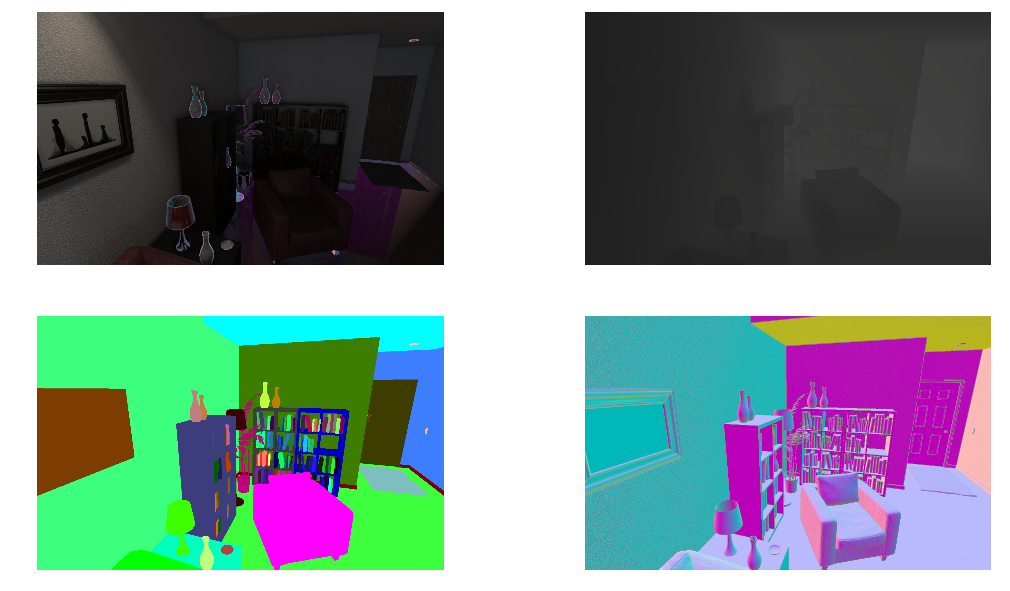

In [24]:
pos = camera_pos[1]
f = render_frame(ue4cv.client, pos)
plt.rcParams['figure.figsize'] = (18.0, 10.0) # (w, h)
plot_rendered_frame(f)

Check how many objects in the scene and the portion

WallPiece1_22 (R=63,G=255,B=127,A=255)
SM_Shelving_6 (R=63,G=63,B=127,A=255)
SM_Couch_1seat_5 (R=255,G=0,B=255,A=255)
SM_Frame_39 (R=127,G=63,B=0,A=255)
SM_Shelving_7 (R=63,G=63,B=63,A=255)
SM_Shelving_8 (R=0,G=0,B=191,A=255)


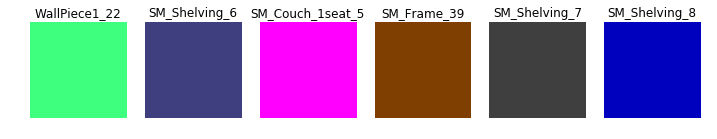

In [25]:
# color_mapping = get_color_mapping(ue4cv.client, objects)
color_mapping = get_color_mapping(ue4cv.client)
objects = ['WallPiece1_22', 'SM_Shelving_6', 'SM_Couch_1seat_5', 'SM_Frame_39', 'SM_Shelving_7', 'SM_Shelving_8']
plt.rcParams['figure.figsize'] = (12.0, 6.0) # (w, h)
plot_object_color(objects, color_mapping)

In [26]:
color_object_mask = plt.imread(f.object_mask)
object_instance_map = ObjectInstanceMap(color_object_mask, color_mapping)

In [45]:
all_objects = color_mapping.keys()
print 'Num of objects in the scene:', len(all_objects)
image_objects = object_instance_map.dic_object_instance.keys()
print 'Num of objects in the image:', len(image_objects)

Num of objects in the scene: 295
Num of objects in the image: 64


In [46]:
# object_instance_map.print_object_size()
object_instance_map.check_coverage()

0.978284375


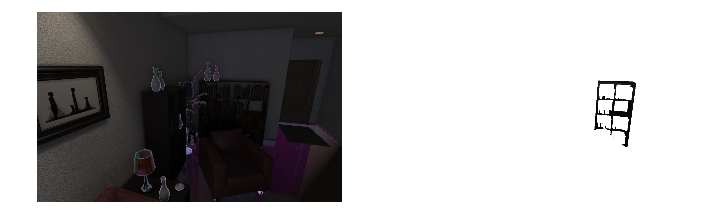

In [39]:
plot_object_region(f.lit, object_instance_map.dic_object_instance['SM_Shelving_8'])

Get the instance region of these objects

Get color of a few selectect objects